# LigthGBM - CLASSIFICATION - BAYESIAN OPTIMIZATION

In [1]:
import numpy as np
from scipy.stats import uniform as sp_rand
from sklearn import datasets
import lightgbm as lgb
from lightgbm import LGBMClassifier
from bayes_opt import BayesianOptimization
import pandas as pd
from datetime import datetime
from time import time

In [2]:
from sklearn.metrics import roc_auc_score, auc

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import gc

In [47]:
import seaborn as sns

In [48]:
from sklearn.metrics import confusion_matrix

In [49]:
from sklearn.metrics import roc_auc_score, roc_curve
%matplotlib inline
import matplotlib.pyplot as plt

In [50]:
def plot_score_dist(y_true, y_score):
    
    df = pd.DataFrame(data=np.column_stack((y_true, y_score)), columns=['target','score'])
    
    plt.figure(figsize=(7, 4))
    ax = sns.boxplot(x="target", y="score", data=df)
    ax.set_title("Score distribution")

    pass

In [51]:
def plot_roc_curve(true_labels, scores):
    ### actual code for roc + threshold charts start here 
    # compute fpr, tpr, thresholds and roc_auc
    fpr, tpr, thresholds = roc_curve(true_labels, scores)
    roc_auc = auc(fpr, tpr) # compute area under the curve

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

    # create the axis of thresholds (scores)
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold',color='r')
    ax2.set_ylim([thresholds[-1],thresholds[0]])
    ax2.set_xlim([fpr[0],fpr[-1]])

    plt.show()
    
    pass

In [85]:
def find_optimal_cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

In [65]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [classes[c] for c in unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### GLOBAL VARIABLES

In [5]:
DATAPATH = 'data/train_test/'
SEED = 47
NITER = 20
CV = 3
SCORE = 'roc_auc'
handlingnull = False
NJOBS = -1
USEGPU = False
NCLASS = 3 # number class to predict (if bivar set 0)

### LOAD DATASET

#### train

In [6]:
train_features = X = pd.read_pickle('data/processed/X.pkl')

In [7]:
train_labels = pd.read_pickle('data/processed/y.pkl')

In [8]:
y_train = train_labels.copy()

In [9]:
train_labels = train_labels['target']

In [10]:
campaign = pd.read_pickle('data/features/campaign_quarter_001.pkl')

In [11]:
digital = pd.read_pickle('data/features/digital_features_period_001.pkl')

In [12]:
rcc = pd.read_pickle('data/features/X_rcc_features_ten_001.pkl')

In [13]:
rcc.drop(['id_persona', 'codmes'], inplace=True, axis=1)

In [14]:
train_features = train_features.join(campaign).join(rcc).join(digital)

#### submit

In [15]:
submit_features = X = pd.read_pickle('data/processed/submission.pkl')

In [16]:
campaign = pd.read_pickle('data/features/campaign_quarter_001.pkl')

In [17]:
digital = pd.read_pickle('data/features/digital_features_period_001.pkl')

In [18]:
rcc = pd.read_pickle('data/features/submit_rcc_features_ten_001.pkl')

In [19]:
rcc.drop(['id_persona', 'codmes'], inplace=True, axis=1)

In [20]:
submit_features = submit_features.join(campaign).join(rcc).join(digital)

In [21]:
del(campaign)
del(digital)
del(rcc)

### TRAIN MODEL

#### Set Search hyperparameters

In [22]:
# ======== General Parameters ======= #

# Select the type of model to run at each iteration. gbtree or gblinear.
boosting = 'gbdt'


# ======== Booster Parameters ======== # 

# Analogous to learning rate in GBM. 
# Typical final values to be used: 0.01-0.2
eta = 0.01


# A node is split only when the resulting split gives a positive reduction in the loss function. 
# Gamma specifies the minimum loss reduction required to make a split.
gamma = [i/10.0 for i in range(0,5)]


# Control the balance of positive and negative weights, useful for unbalanced classes. 
# A typical value to consider: sum(negative instances) / sum(positive instances)scale_pos_weight = 1
scale_pos_weight = (len(train_labels) - sum(train_labels))/sum(train_labels)


# Learning Task Parameters
# This defines the loss function to be minimized. See documentation
# -  options: regression, regression_l1, huber, fair, poisson, quantile, 
# mape, gamma, tweedie, binary, multiclass, multiclassova, cross_entropy, cross_entropy_lambda,
# lambdarank, aliases: objective_type, app, application
objective  = 'binary'


# The metric to be used for validation data.
# - rmse, root square loss, aliases: root_mean_squared_error, l2_root
# - quantile, Quantile regression
# - mape, MAPE loss, aliases: mean_absolute_percentage_error
# - huber, Huber loss
# - fair, Fair loss
# - poisson, negative log-likelihood for Poisson regression
# - gamma, negative log-likelihood for Gamma regression
# - gamma_deviance, residual deviance for Gamma regression
# - tweedie, negative log-likelihood for Tweedie regression
# - ndcg, NDCG, aliases: lambdarank
# - map, MAP, aliases: mean_average_precision
# - auc, AUC
# - binary_logloss, log loss, aliases: binary
metric = 'auc'

[lightGBM params](https://lightgbm.readthedocs.io/en/latest/Parameters.html)


#### load hyperparameters

In [24]:
model_param = np.load('output/models/bayesianopt_gbm_classifier_bestparams_d2019-11-24.npy').tolist()

In [25]:
model_param

{'bagging_fraction': 0.8152616578747914,
 'feature_fraction': 0.7239350337920917,
 'max_depth': 10.753636925763574,
 'min_child_weight': 44.469303556618826,
 'min_split_gain': 0.09782096168766367,
 'num_leaves': 63.079669632834694,
 'n_estimators': 364}

In [26]:
model_param['max_depth'] = int(np.round(model_param['max_depth'],0))
model_param['min_child_weight'] = int(np.round(model_param['min_child_weight'],0))
model_param['num_leaves'] = int(np.round(model_param['num_leaves'],0))

In [27]:
model_param['boosting_type'] = boosting
model_param['objective'] = objective
model_param['learning_rate'] = eta
model_param['metric'] = metric
model_param['seed'] = SEED

In [28]:
model_param

{'bagging_fraction': 0.8152616578747914,
 'feature_fraction': 0.7239350337920917,
 'max_depth': 11,
 'min_child_weight': 44,
 'min_split_gain': 0.09782096168766367,
 'num_leaves': 63,
 'n_estimators': 364,
 'boosting_type': 'gbdt',
 'objective': 'binary',
 'learning_rate': 0.01,
 'metric': 'auc',
 'seed': 47}

### Cross Period

In [29]:
gc.collect()

170

In [54]:
drop_cols = ["codmes"]
fi = []
test_probs = []
train_probs = []




for m in train_features.codmes.unique():
    print('-'*10, str(m),'-'*10)
    Xt = train_features[train_features.codmes != m]
    yt = train_labels[train_labels.index.isin(Xt.index)]
    Xt = Xt.drop(drop_cols, axis=1)

    Xv = train_features[train_features.codmes == m]
    yv = train_labels[train_labels.index.isin(Xv.index)]

    model = LGBMClassifier().set_params(**model_param)
    #res = model.fit(Xt, yt,  eval_metric=metric, verbose=50)

    res = model.fit(Xt, yt,  early_stopping_rounds=10, eval_metric=metric,
                eval_set=[(Xt, yt), (Xv.drop(drop_cols, axis=1), yv)], verbose=50)
    pred = model.predict_proba(Xv.drop(drop_cols, axis=1))[:, -1]

    #test_auc.append(roc_auc_score(yv.values, pred))

    train_probs.append(pd.Series(pred,
                            index=Xv.index, name="probs"))
    
    gc.collect()
    test_probs.append(pd.Series(model.predict_proba(submit_features.drop(drop_cols, axis=1))[:, -1],
                                index=submit_features.index, name="fold_" + str(m)))
    gc.collect()

---------- 201901 ----------
Training until validation scores don't improve for 10 rounds.
[50]	training's auc: 0.791596	valid_1's auc: 0.768277
[100]	training's auc: 0.799085	valid_1's auc: 0.773005
[150]	training's auc: 0.805544	valid_1's auc: 0.776357
[200]	training's auc: 0.81187	valid_1's auc: 0.779475
[250]	training's auc: 0.816872	valid_1's auc: 0.781544
[300]	training's auc: 0.821313	valid_1's auc: 0.782992
[350]	training's auc: 0.825153	valid_1's auc: 0.784276
Did not meet early stopping. Best iteration is:
[364]	training's auc: 0.826127	valid_1's auc: 0.784549
---------- 201903 ----------
Training until validation scores don't improve for 10 rounds.
[50]	training's auc: 0.788114	valid_1's auc: 0.785547
[100]	training's auc: 0.795641	valid_1's auc: 0.790392
[150]	training's auc: 0.80263	valid_1's auc: 0.794175
[200]	training's auc: 0.808518	valid_1's auc: 0.797147
[250]	training's auc: 0.814282	valid_1's auc: 0.799895
[300]	training's auc: 0.819144	valid_1's auc: 0.801982
[350

In [34]:
len(test_probs[1])

178685

In [35]:
submit_features.shape

(178685, 1770)

#### cutoff 201901

In [62]:
from scipy.optimize import differential_evolution

#res = test_labels.join(pd.concat(y_pred).rename("probs"))
optimization = differential_evolution(lambda c: -((train_probs[0] > c[0]) * y_train[y_train.codmes == 201901].margen / y_train[y_train.codmes == 201901].margen.sum()).sum(), [(0, 1)])
optimization

     fun: -1.292511073267082
 message: 'Optimization terminated successfully.'
    nfev: 107
     nit: 6
 success: True
       x: array([0.060631])

In [66]:
cutoff = optimization["x"][0]

In [63]:
print(SCORE,' : ', roc_auc_score(y_train[y_train.codmes == 201901].target,train_probs[0]))

roc_auc  :  0.784548811129389


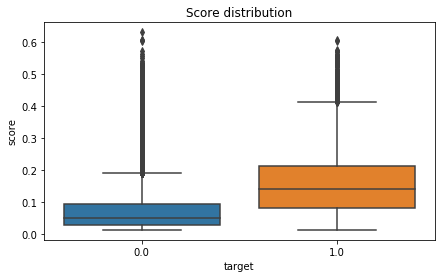

In [64]:
plot_score_dist(y_train[y_train.codmes == 201901].target,train_probs[0])

In [73]:
# Find prediction to the dataframe applying threshold
y_pred_201901 = np.where(test_probs[0] > cutoff,1,0)

In [74]:
y_pred_201901

array([0, 1, 0, ..., 0, 1, 0])

#### cutoff 201903

In [80]:
from scipy.optimize import differential_evolution

#res = test_labels.join(pd.concat(y_pred).rename("probs"))
optimization = differential_evolution(lambda c: -((train_probs[1] > c[0]) * y_train[y_train.codmes == 201903].margen / y_train[y_train.codmes == 201903].margen.sum()).sum(), [(0, 1)])
optimization

     fun: -1.0929904551663363
 message: 'Optimization terminated successfully.'
    nfev: 107
     nit: 6
 success: True
       x: array([0.05248487])

In [81]:
cutoff = optimization["x"][0]

In [94]:
cutoff = find_optimal_cutoff(y_train[y_train.codmes == 201903].target, train_probs[1])[0]

In [88]:
print(SCORE,' : ', roc_auc_score(y_train[y_train.codmes == 201903].target,train_probs[1]))

roc_auc  :  0.8041521500093585


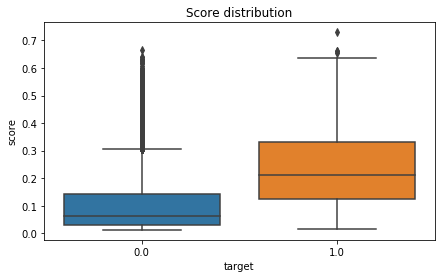

In [89]:
plot_score_dist(y_train[y_train.codmes == 201903].target,train_probs[1])

In [95]:
# Find prediction to the dataframe applying threshold
y_pred_201903 = np.where(test_probs[1] > cutoff,1,0)

#### cutoff 201902

In [97]:
#res = test_labels.join(pd.concat(y_pred).rename("probs"))
optimization = differential_evolution(lambda c: -((train_probs[2] > c[0]) * y_train[y_train.codmes == 201902].margen / y_train[y_train.codmes == 201902].margen.sum()).sum(), [(0, 1)])
optimization

     fun: -1.1403560667328474
 message: 'Optimization terminated successfully.'
    nfev: 107
     nit: 6
 success: True
       x: array([0.04354558])

In [98]:
cutoff = optimization["x"][0]

In [102]:
cutoff

0.08830761587781594

In [99]:
cutoff = find_optimal_cutoff(y_train[y_train.codmes == 201902].target, train_probs[2])[0]

In [100]:
print(SCORE,' : ', roc_auc_score(y_train[y_train.codmes == 201902].target,train_probs[2]))

roc_auc  :  0.7762987079996253


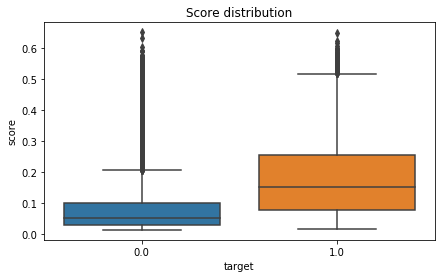

In [101]:
plot_score_dist(y_train[y_train.codmes == 201902].target,train_probs[2])

In [103]:
# Find prediction to the dataframe applying threshold
y_pred_201902 = np.where(test_probs[2] > cutoff,1,0)

#### cutoff 201904

In [104]:
from scipy.optimize import differential_evolution

#res = test_labels.join(pd.concat(y_pred).rename("probs"))
optimization = differential_evolution(lambda c: -((train_probs[3] > c[0]) * y_train[y_train.codmes == 201904].margen / y_train[y_train.codmes == 201904].margen.sum()).sum(), [(0, 1)])
optimization

     fun: -1.1433435055817993
 message: 'Optimization terminated successfully.'
    nfev: 77
     nit: 4
 success: True
       x: array([0.04893086])

In [105]:
cutoff = optimization["x"][0]

In [106]:
cutoff = find_optimal_cutoff(y_train[y_train.codmes == 201904].target, train_probs[3])[0]

In [109]:
cutoff

0.10572846468516182

In [107]:
print(SCORE,' : ', roc_auc_score(y_train[y_train.codmes == 201904].target,train_probs[3]))

roc_auc  :  0.8064282302869383


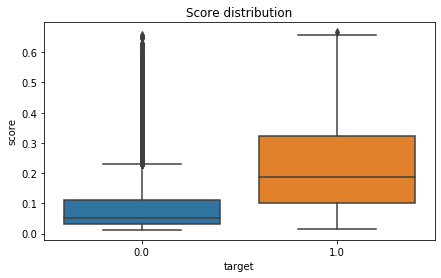

In [108]:
plot_score_dist(y_train[y_train.codmes == 201904].target,train_probs[3])

In [110]:
# Find prediction to the dataframe applying threshold
y_pred_201904 = np.where(test_probs[3] > cutoff,1,0)

In [116]:
sales = [('y_pred_201904', y_pred_201904),
         ('y_pred_201903', y_pred_201903),
         ('y_pred_201902', y_pred_201902),
         ('y_pred_201901', y_pred_201901),
         ]
df = pd.DataFrame.from_items(sales)

In [120]:
submit_features.index

Index(['123381_201907', '125277_201906', '9564_201906', '249494_201906',
       '131234_201907', '17651_201907', '211794_201905', '224194_201907',
       '11651_201907', '172417_201906',
       ...
       '70520_201905', '39259_201906', '181859_201907', '28563_201907',
       '180546_201907', '124159_201907', '82989_201907', '96180_201907',
       '142533_201906', '43533_201905'],
      dtype='object', name='prediction_id', length=178685)

In [122]:
df.index = submit_features.index

In [125]:
df['sum_pred'] =  df.sum(axis=1)

In [137]:
del df['class']

In [129]:
df['class'] = np.where(df['sum_pred'] > 2, 1, 0)

In [138]:
df['class'] =  df.max(axis=1)

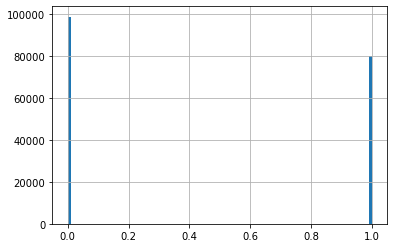

In [139]:
df['class'].hist(bins=100)
pass

In [140]:
df.reset_index(inplace=True)

In [142]:
submit = df[['prediction_id', 'class']].sort_values(by='prediction_id')
submit.to_csv("output/submits/submit_008.csv", index=False, header=True)